# **Deep Dive Project - Group 10**
### Analyzing and Predicting California's Unemployment Rate Using Deep Learning

## Milestone 1:

In [ ]:
import numpy as np # numpy for computation
import pandas as pd  # pandas library for computation
import matplotlib.pyplot as plt   # for displaying output visualization in matplotlib
import seaborn as sns   # for displaying output visualization in seaborn
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.linear_model import LinearRegression # for linear regression classifier
from sklearn.metrics import mean_squared_error, r2_score # for computing mean square error and R-square error
from sklearn.preprocessing import StandardScaler   # for scaling the data
from sklearn.linear_model import Ridge # for ridge regression classifier
from sklearn.pipeline import make_pipeline # for making pipeline
from sklearn.tree import DecisionTreeRegressor # for decision tree regression classifier

In [ ]:
pip install optuna

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna

#### Loading Dataset

In [ ]:
def getfile(location_pair,indict={}): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,*indict)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pd.read_csv(loc,*indict)
    return out

In [ ]:
fname=("Local Area Unemployment Statistics (LAUS).csv","https://drive.google.com/file/d/1PhDuxwfj42OqDN9XnLx56UbXgY5SNQTC/view?usp=sharing")
data = getfile(fname)
data.info()
data.head(5)

local file not found; accessing Google Drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203072 entries, 0 to 203071
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   _id                       203072 non-null  int64  
 1   Area Name                 203072 non-null  object 
 2   Area Type                 203072 non-null  object 
 3   Year                      203072 non-null  int64  
 4   Month                     203072 non-null  object 
 5   Date_Numeric              203072 non-null  object 
 6   Seasonally Adjusted(Y/N)  203072 non-null  object 
 7   Status                    203072 non-null  object 
 8   Labor Force               203072 non-null  int64  
 9   Employment                203072 non-null  int64  
 10  Unemployment              203072 non-null  int64  
 11  Unemployment Rate         203072 non-null  float64
 12  Benchmark                 203072 non-null  int64  
dtyp

,_id,Area Name,Area Type,Year,Month,Date_Numeric,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark
0,1,California,State,1976,January,01/1976,N,Final,9672362,8668016,1004346,10.4,2020
1,2,California,State,1976,January,01/1976,Y,Final,9774280,8875685,898595,9.2,2020
2,3,California,State,1976,February,02/1976,N,Final,9684440,8704564,979876,10.1,2020
3,4,California,State,1976,February,02/1976,Y,Final,9768885,8871553,897332,9.2,2020
4,5,California,State,1976,March,03/1976,N,Final,9689626,8776344,913282,9.4,2020


In [ ]:
data['Date_Numeric'] = pd.to_datetime(data['Date_Numeric'], format='%m/%Y')
data['Date'] = pd.to_datetime(data['Date_Numeric'], format='%Y')
#data.drop(['Year', 'Month'], axis=1, inplace=True)
data['Year'] = pd.to_datetime(data['Year'], format='%Y')
data['Benchmark'] = pd.to_datetime(data['Benchmark'], format='%Y')
data['Employment Rate']= np.round(data['Employment']/data['Labor Force'],2)
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203072 entries, 0 to 203071
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   _id                       203072 non-null  int64         
 1   Area Name                 203072 non-null  object        
 2   Area Type                 203072 non-null  object        
 3   Year                      203072 non-null  datetime64[ns]
 4   Month                     203072 non-null  object        
 5   Date_Numeric              203072 non-null  datetime64[ns]
 6   Seasonally Adjusted(Y/N)  203072 non-null  object        
 7   Status                    203072 non-null  object        
 8   Labor Force               203072 non-null  int64         
 9   Employment                203072 non-null  int64         
 10  Unemployment              203072 non-null  int64         
 11  Unemployment Rate         203072 non-null  float64       
 12  Be

,_id,Area Name,Area Type,Year,Month,Date_Numeric,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark,Date,Employment Rate
0,1,California,State,1976-01-01,January,1976-01-01,N,Final,9672362,8668016,1004346,10.4,2020-01-01,1976-01-01,0.90
1,2,California,State,1976-01-01,January,1976-01-01,Y,Final,9774280,8875685,898595,9.2,2020-01-01,1976-01-01,0.91
2,3,California,State,1976-01-01,February,1976-02-01,N,Final,9684440,8704564,979876,10.1,2020-01-01,1976-02-01,0.90
3,4,California,State,1976-01-01,February,1976-02-01,Y,Final,9768885,8871553,897332,9.2,2020-01-01,1976-02-01,0.91
4,5,California,State,1976-01-01,March,1976-03-01,N,Final,9689626,8776344,913282,9.4,2020-01-01,1976-03-01,0.91


#### Pickle the Datasets

In [ ]:
# Create and pickle the debugging dataset
debugging_data = data.sample(frac=0.01, random_state=42)   # 1% of the original data
debugging_data.to_pickle('debugging_data.pkl')

# Create and pickle the working dataset
working_data = data.sample(frac=0.3, random_state=42)   # 30% of the original data
working_data.to_pickle('working_data.pkl')

# Pickle the original dataset
data.to_pickle('original_data.pkl')

#### Loading Pickled Datasets

In [ ]:
# Load the pickled datasets
debugging_data = pd.read_pickle('debugging_data.pkl')
working_data = pd.read_pickle('working_data.pkl')
original_data = pd.read_pickle('original_data.pkl')

## Milestone 2:

In [ ]:
original_data.describe()

,_id,Year,Date_Numeric,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark,Date,Employment Rate
count,203072.00000,203072,203072,2.030720e+05,2.030720e+05,2.030720e+05,203072.000000,203072,203072,199730.000000
mean,101536.50000,2014-10-22 01:22:10.286794752,2015-04-04 07:14:02.704065536,2.107999e+05,1.958159e+05,1.498387e+04,8.417330,2022-10-26 07:18:37.554365184,2015-04-04 07:14:02.704065536,0.916448
min,1.00000,1976-01-01 00:00:00,1976-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2020-01-01 00:00:00,1976-01-01 00:00:00,0.000000
25%,50768.75000,2012-01-01 00:00:00,2012-04-01 00:00:00,1.500000e+03,1.300000e+03,1.000000e+02,4.000000,2023-01-01 00:00:00,2012-04-01 00:00:00,0.890000
50%,101536.50000,2016-01-01 00:00:00,2016-05-01 00:00:00,7.600000e+03,7.000000e+03,5.000000e+02,6.600000,2023-01-01 00:00:00,2016-05-01 00:00:00,0.930000
75%,152304.25000,2020-01-01 00:00:00,2020-07-01 00:00:00,3.560000e+04,3.350000e+04,2.400000e+03,10.800000,2023-01-01 00:00:00,2020-07-01 00:00:00,0.960000
max,203072.00000,2024-01-01 00:00:00,2024-08-01 00:00:00,1.970080e+07,1.884210e+07,3.015300e+06,100.000000,2023-01-01 00:00:00,2024-08-01 00:00:00,1.000000
std,58621.98127,NaN,NaN,1.328436e+06,1.235057e+06,9.926123e+04,7.368371,NaN,NaN,0.078886


In [ ]:
# Selecting data for analysis
df = debugging_data

#### Data Visualization

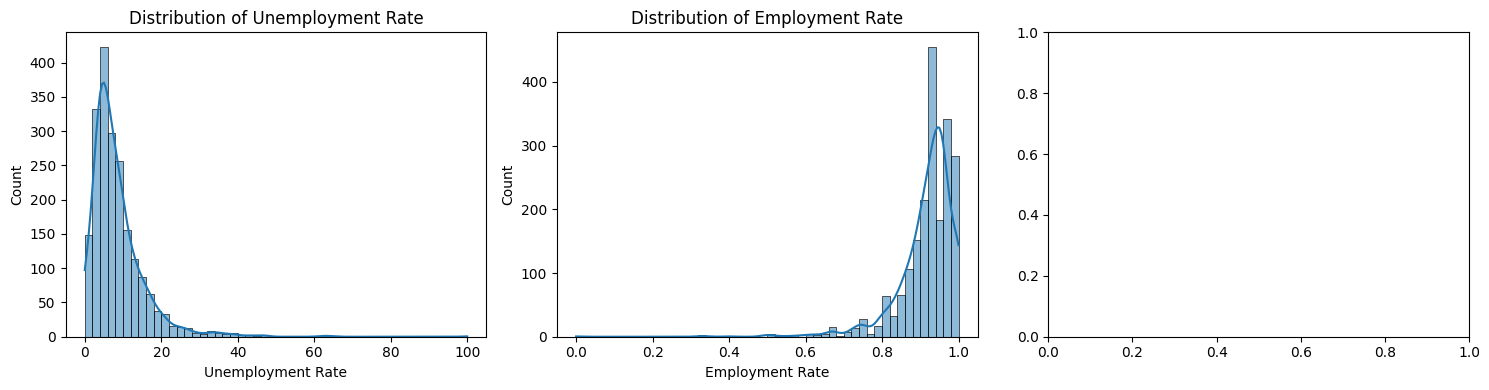

<Figure size 400x400 with 0 Axes>

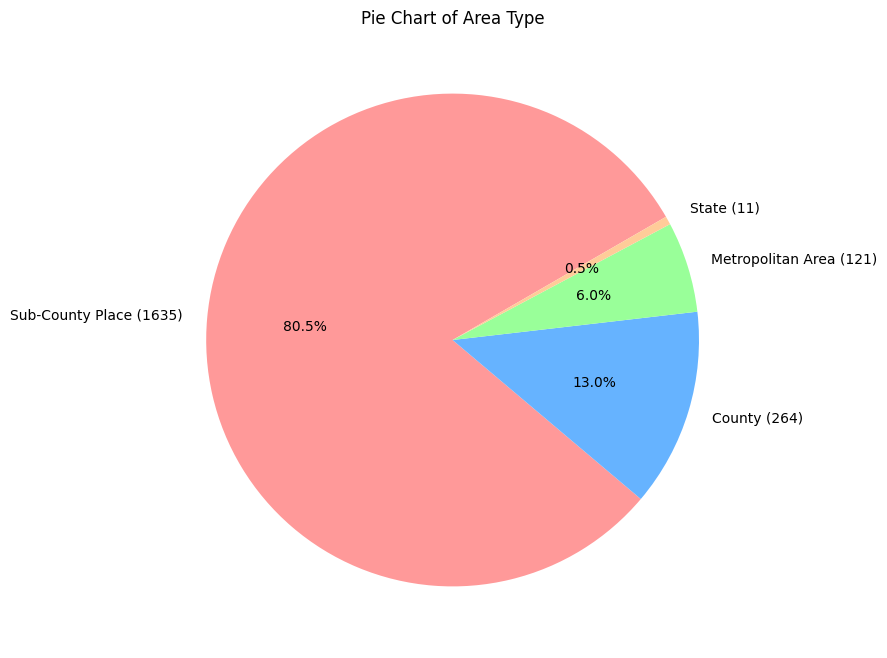

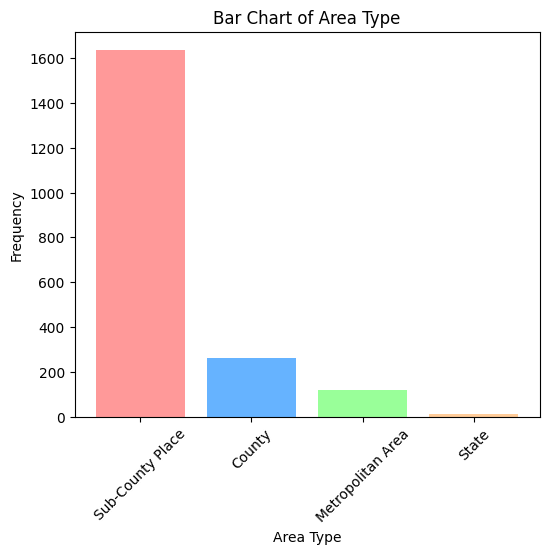

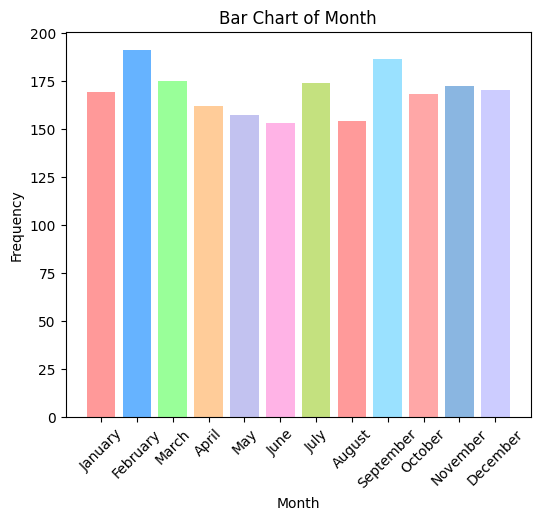

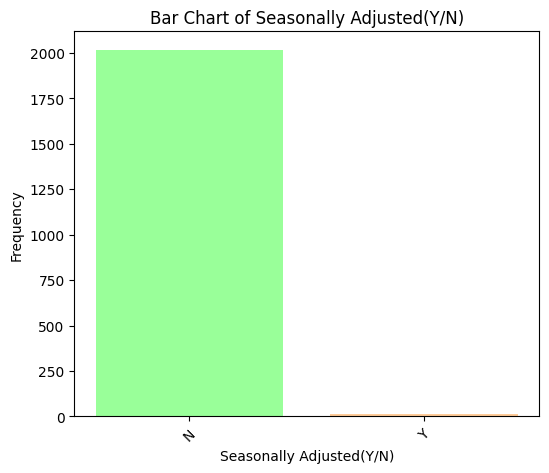

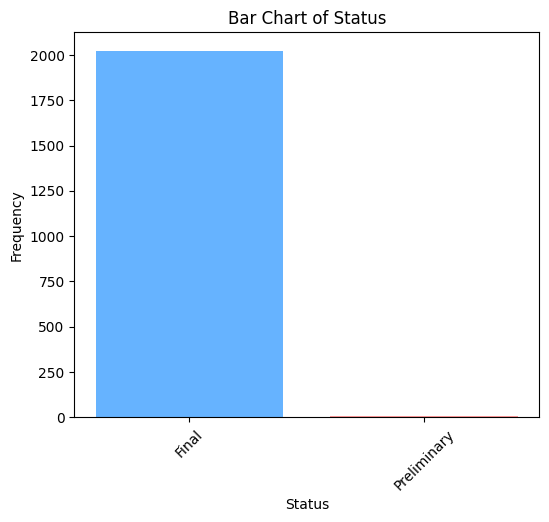

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(df['Unemployment Rate'], bins=50, ax=ax[0], kde=True)
ax[0].set_title("Distribution of Unemployment Rate")
ax[0].set_xlabel("Unemployment Rate")

sns.histplot(df['Employment Rate'], bins=50, ax=ax[1], kde=True)
ax[1].set_title("Distribution of Employment Rate")
ax[1].set_xlabel("Employment Rate")

#sns.histplot(df['Labor Force'], bins=50, ax=ax[2], kde=True)
#ax[2].set_title("Distribution of Labor Force")
#ax[2].set_xlabel("Labor Force")

plt.tight_layout()
plt.show()

# Defining custom colors
custom_colors = {
    'Area Type': ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'],
    'Month': ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c4e17f', '#ff9a9a', '#9ae1ff', '#ffa7a7', '#8ab6e1', '#ccccff'],
    'Seasonally Adjusted(Y/N)': ['#99ff99', '#ffcc99'],
    'Status': ['#66b3ff', '#ff9999']
}

# For Pie charts
for column in (['Area Type']):
  plt.figure(figsize=(4,4))
  counts = df[column].value_counts()
  original_labels = counts.index.tolist()
  new_labels = [f"{label} ({count})" for label, count in zip(original_labels, counts)]
  sizes = counts.values
  plt.figure(figsize=(8, 8))
  plt.pie(sizes, labels=new_labels, autopct='%1.1f%%', startangle=30, colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
  plt.title(f'Pie Chart of {column}')
  plt.show()

# Define the correct order for months
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# For Bar graphs
for column in (['Area Type','Month', 'Seasonally Adjusted(Y/N)', 'Status']):
  plt.figure(figsize=(6,5))
  counts = df[column].value_counts()
  if column == 'Month':
    counts = counts.reindex(month_order)
  plt.bar(counts.index, counts.values, color=custom_colors[column][:len(counts)])
  plt.title(f'Bar Chart of {column}')
  plt.xlabel(column)
  plt.ylabel('Frequency')
  plt.xticks(rotation=45)
  plt.show()

* **Unemployment Rate:** The histogram shows a highly skewed distribution with most values concentrated at the lower end, indicating a long tail for higher unemployment rates. This suggests potential imbalance where most areas experience lower unemployment, and a few have significantly high rates.
* **Employment Rate:** The distribution here is also skewed, with most values concentrated close to 1, indicating that high employment rates are common. This could present challenges in modeling due to low variability.
* **Labor Force:** The labor force distribution is similarly skewed with a concentration near the lower end, but with some extremely high values representing large labor force areas, possibly outliers that might need special handling or transformation.
* **Area Type:** The pie chart and bar chart indicate that most data points belong to "Sub-County Place" areas, with much smaller representations from "County" and other types. This imbalance could affect the analysis by potentially over-representing characteristics of sub-county places and under-representing those of counties or metropolitan areas.
* **Month:** While month-wise data is relatively balanced, as seen in the bar chart, some minor variation might impact monthly trends slightly, but overall, it appears fairly representative across months.
* **Seasonally Adjusted and Status:** There is a stark imbalance here, with "Final" status dominating and "Non-seasonally adjusted" data making up the majority. This may impact the analysis as it might introduce bias or affect robustness.

##### Trend Analysis over time

<ipython-input-61-d05af9a336ca>:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_resampled = numeric_df.resample('Y').mean()


<Figure size 1400x600 with 0 Axes>

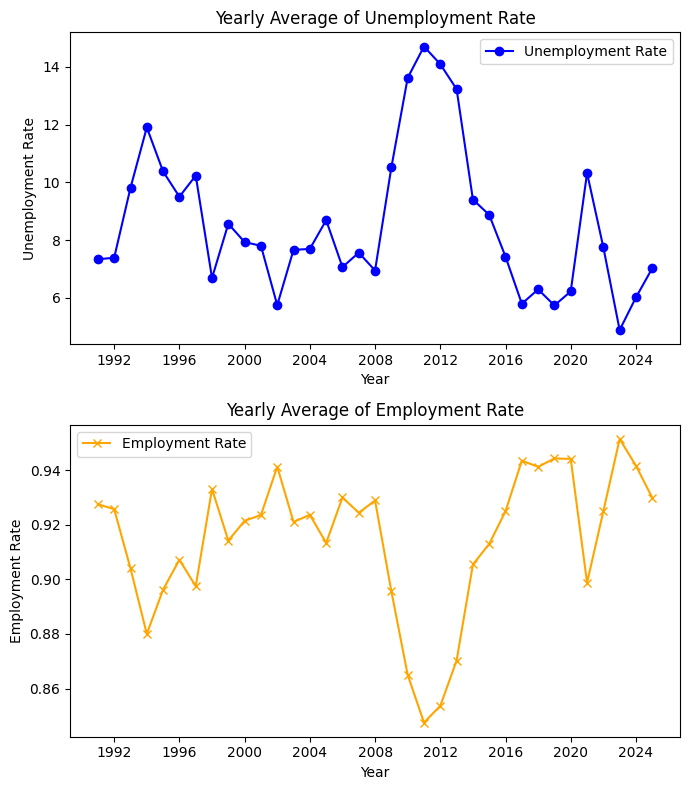

In [ ]:
plt.figure(figsize=(14, 6))

# Ensure 'Date' is set as the index
df.set_index('Date', inplace=True)

# Select only numeric columns for resampling
numeric_df = df[['Unemployment Rate', 'Employment Rate']]

# Resample by year and calculate the mean
df_resampled = numeric_df.resample('Y').mean()
df_resampled = df_resampled[df_resampled.index >= '1990']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))

# Plot for Unemployment Rate
axes[0].plot(df_resampled.index, df_resampled['Unemployment Rate'], color='blue', marker='o', label='Unemployment Rate')
axes[0].set_title("Yearly Average of Unemployment Rate")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Unemployment Rate")
axes[0].legend()

# Plot for Employment Rate
axes[1].plot(df_resampled.index, df_resampled['Employment Rate'], color='orange', marker='x', label='Employment Rate')
axes[1].set_title("Yearly Average of Employment Rate")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Employment Rate")
axes[1].legend()

plt.tight_layout()
plt.show()

##### Correlation Matrix

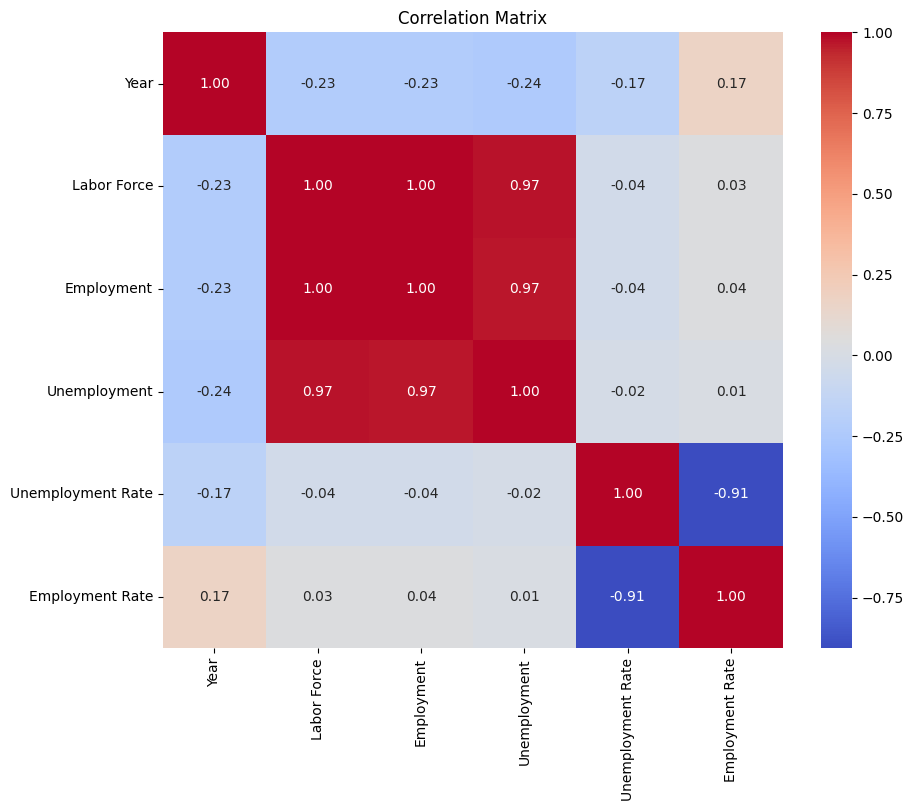

In [ ]:
# Calculating correlations for numerical fields
numeric_df = df[['Year', 'Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate', 'Employment Rate']]
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

The heatmap shows strong positive correlations between "Labor Force" and "Employment" and "Unemployment" variables, as expected. However, there’s a strong negative correlation between "Unemployment Rate" and "Employment Rate," which could influence model accuracy. The high correlations among certain variables may require careful feature selection to avoid multicollinearity.

#### Handling Missing or Imbalanced Data

In [ ]:
# Check for missing values
missing_data = df.isnull().sum()
df['Employment Rate'].fillna(0, inplace=True)
print("Missing data per column:\n", missing_data)

# Basic Imbalance Check - Count by Seasonally Adjusted and Status
print("\nSeasonally Adjusted Counts:\n", df['Seasonally Adjusted(Y/N)'].value_counts())
print("\nStatus Counts:\n", df['Status'].value_counts())

Missing data per column:
 _id                          0
Area Name                    0
Area Type                    0
Year                         0
Month                        0
Date_Numeric                 0
Seasonally Adjusted(Y/N)     0
Status                       0
Labor Force                  0
Employment                   0
Unemployment                 0
Unemployment Rate            0
Benchmark                    0
Employment Rate             24
dtype: int64

Seasonally Adjusted Counts:
 Seasonally Adjusted(Y/N)
N    2016
Y      15
Name: count, dtype: int64

Status Counts:
 Status
Final          2025
Preliminary       6
Name: count, dtype: int64


<ipython-input-63-87dec7fe77b5>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Employment Rate'].fillna(0, inplace=True)


In [ ]:
#Updating the missing data
df.loc[:, 'Employment Rate'] = df['Employment Rate'].fillna(0)

#### Perform Linear Regression as Benchmark

In [ ]:
# Select necessary columns for linear regression
X = df.drop('Unemployment Rate', axis=1)
y = df['Unemployment Rate']

X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Scaling the X data for processing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("\nTraining baseline Linear Regression model with scaling...")
# Train a baseline Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = model.score(X_test, y_test)

print(f"RMSE: {rmse:.2f}, R-squared: {r2:.2f}")


Training baseline Linear Regression model with scaling...
RMSE: 5.18, R-squared: 0.41


For the baseline model, we implemented a simple Linear Regression using the `Unemployment Rate` as the target variable. The feature set includes relevant columns like `Labor Force`, `Employment`, and `Unemployment`, which were preprocessed as follows:

1. **Data Cleaning:** To handle any non-numeric entries or missing values, we converted data to numeric format and filled NaN values with 0.

2. **Scaling:** StandardScaler was used to normalize the feature values, as linear regression models perform better with scaled data.

3. **Train-Test Split:** We split the data into training and testing sets in an 80-20 ratio to evaluate model performance.

4. **Model Training and Evaluation:** The Linear Regression model was trained on the scaled data, achieving an RMSE (Root Mean Squared Error) of 5.18 and an R-squared value of 0.41. The R-squared indicates that the model explains 41% of the variance in Unemployment Rate, providing a reasonable baseline for further improvements.

#### Perform Linear, Ridge and Decision Tree Regression

In [ ]:
# Selecting features and target variable
if 'Unemployment Rate' in df.columns:
    X = df.drop(columns=['Unemployment Rate'])
    y = df['Unemployment Rate']
else:
    print("No 'Unemployment Rate' column found")
    X = y = None

if X is not None:
    # Convert datetime columns to numeric
    for col in X.select_dtypes(include=['datetime64']).columns:
        X[col] = X[col].apply(lambda x: x.timestamp())

    # One-hot encoding to convert categorical variables
    X = pd.get_dummies(X, drop_first=True)

    #Linear Regression
    print("\nTraining baseline Linear Regression model...")
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    mse_linear = mean_squared_error(y, y_pred_linear)
    r2_linear = r2_score(y, y_pred_linear)
    print(f"Linear Regression MSE: {mse_linear:.2f}, R2 Score: {r2_linear:.2f}")

    # Ridge Regression
    print("\nTraining baseline Ridge Regression model with scaling...")
    ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=15.0))
    ridge_model.fit(X, y)
    y_pred_ridge = ridge_model.predict(X)
    mse_ridge = mean_squared_error(y, y_pred_ridge)
    r2_ridge = r2_score(y, y_pred_ridge)
    print(f"Ridge Regression (with scaling) MSE: {mse_ridge:.2f}, R2 Score: {r2_ridge:.2f}")

    #Decision Tree Regressor
    print("\nTraining baseline Decision Tree Regressor model...")
    tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
    tree_model.fit(X, y)
    y_pred_tree = tree_model.predict(X)
    mse_tree = mean_squared_error(y, y_pred_tree)
    r2_tree = r2_score(y, y_pred_tree)
    print(f"Decision Tree Regressor MSE: {mse_tree:.2f}, R2 Score: {r2_tree:.2f} \n\n")

    # Additional details about the tree
    n_leaves = tree_model.get_n_leaves()
    n_splits = tree_model.tree_.node_count - n_leaves  # Total nodes - leaves = splits
    print(f"Number of leaves in the Decision Tree: {n_leaves}")
    print(f"Number of splits in the Decision Tree: {n_splits}")

    # Sample predictions vs actual values
    print("\nSample Predictions vs. Actuals (Decision Tree):")
    print(pd.DataFrame({'Actual': y[:5], 'Predicted': y_pred_tree[:5]}))

else:
    print("Unable to proceed : Missing target variable.")



Training baseline Linear Regression model...
Linear Regression MSE: 1.79, R2 Score: 0.97

Training baseline Ridge Regression model with scaling...
Ridge Regression (with scaling) MSE: 2.11, R2 Score: 0.96

Training baseline Decision Tree Regressor model...
Decision Tree Regressor MSE: 4.89, R2 Score: 0.91 


Number of leaves in the Decision Tree: 29
Number of splits in the Decision Tree: 28

Sample Predictions vs. Actuals (Decision Tree):
            Actual  Predicted
Date                         
2014-11-01     0.0   3.588604
2014-08-01     1.5   3.588604
2011-11-01     7.0   6.919853
2010-09-01     9.6  10.475449
1992-07-01    16.2  15.986842


In this model evaluation, we applied three regression methods—Linear Regression, Ridge Regression, and Decision Tree Regression—to predict the `Unemployment Rate` based on various employment and labor force features.

# **Milestone 3**

In [ ]:
df = working_data
X = df.drop('Unemployment Rate', axis=1)
y = df['Unemployment Rate']

X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


In [ ]:
df

,_id,Area Name,Area Type,Year,Month,Date_Numeric,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark,Date,Employment Rate
73739,73740,Greenhorn CDP,Sub-County Place,2014-01-01,November,2014-11-01,N,Final,80,80,0,0.0,2023-01-01,2014-11-01,1.00
81896,81897,Bootjack CDP,Sub-County Place,2014-01-01,August,2014-08-01,N,Final,270,270,0,1.5,2023-01-01,2014-08-01,1.00
35598,35599,Marin County,County,2011-01-01,November,2011-11-01,N,Final,134800,125300,9400,7.0,2023-01-01,2011-11-01,0.93
29121,29122,Eureka city,Sub-County Place,2010-01-01,September,2010-09-01,N,Final,13600,12300,1300,9.6,2023-01-01,2010-09-01,0.90
3797,3798,Tulare County,County,1992-01-01,July,1992-07-01,N,Final,154500,129400,25100,16.2,2021-01-01,1992-07-01,0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133260,133261,Davis city,Sub-County Place,2018-01-01,December,2018-12-01,N,Final,35300,34400,900,2.6,2023-01-01,2018-12-01,0.97
186132,186133,Coronado city,Sub-County Place,2023-01-01,December,2023-12-01,N,Final,8100,7800,300,3.6,2023-01-01,2023-12-01,0.96
192663,192664,Avocado Heights CDP,Sub-County Place,2023-01-01,April,2023-04-01,N,Final,6800,6500,300,4.2,2023-01-01,2023-04-01,0.96
37326,37327,Hidden Hills city,Sub-County Place,2011-01-01,February,2011-02-01,N,Final,900,800,100,8.1,2023-01-01,2011-02-01,0.89


In [ ]:
X

,_id,Area Name,Area Type,Year,Month,Date_Numeric,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Benchmark,Date,Employment Rate
73739,73740,0.0,0.0,1388534400000000000,0.0,1414800000000000000,0.0,0.0,80,80,0,1672531200000000000,1414800000000000000,1.00
81896,81897,0.0,0.0,1388534400000000000,0.0,1406851200000000000,0.0,0.0,270,270,0,1672531200000000000,1406851200000000000,1.00
35598,35599,0.0,0.0,1293840000000000000,0.0,1320105600000000000,0.0,0.0,134800,125300,9400,1672531200000000000,1320105600000000000,0.93
29121,29122,0.0,0.0,1262304000000000000,0.0,1283299200000000000,0.0,0.0,13600,12300,1300,1672531200000000000,1283299200000000000,0.90
3797,3798,0.0,0.0,694224000000000000,0.0,709948800000000000,0.0,0.0,154500,129400,25100,1609459200000000000,709948800000000000,0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133260,133261,0.0,0.0,1514764800000000000,0.0,1543622400000000000,0.0,0.0,35300,34400,900,1672531200000000000,1543622400000000000,0.97
186132,186133,0.0,0.0,1672531200000000000,0.0,1701388800000000000,0.0,0.0,8100,7800,300,1672531200000000000,1701388800000000000,0.96
192663,192664,0.0,0.0,1672531200000000000,0.0,1680307200000000000,0.0,0.0,6800,6500,300,1672531200000000000,1680307200000000000,0.96
37326,37327,0.0,0.0,1293840000000000000,0.0,1296518400000000000,0.0,0.0,900,800,100,1672531200000000000,1296518400000000000,0.89


In [ ]:
print(X.shape)
print(y.shape)
print(X_scaled.shape)
print(y_scaled.shape)

(60922, 14)
(60922,)
(60922, 14)
(60922, 1)


In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        return out

In [ ]:
model = RNNModel(X_train.shape[1], 64, 0.2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000
model.train()
for epoch in range(num_epochs):
    outputs = model(X_train_tensor.unsqueeze(1))
    loss = criterion(outputs.squeeze(), y_train_tensor.squeeze())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor.squeeze())
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/1000], Loss: 120.0501
Epoch [20/1000], Loss: 116.7550
Epoch [30/1000], Loss: 113.1065
Epoch [40/1000], Loss: 108.9702
Epoch [50/1000], Loss: 104.3252
Epoch [60/1000], Loss: 99.3686
Epoch [70/1000], Loss: 94.1057
Epoch [80/1000], Loss: 88.8564
Epoch [90/1000], Loss: 83.6581
Epoch [100/1000], Loss: 78.6709
Epoch [110/1000], Loss: 73.9048
Epoch [120/1000], Loss: 69.2661
Epoch [130/1000], Loss: 64.5669
Epoch [140/1000], Loss: 59.9107
Epoch [150/1000], Loss: 55.0432
Epoch [160/1000], Loss: 51.1157
Epoch [170/1000], Loss: 48.1299
Epoch [180/1000], Loss: 45.6424
Epoch [190/1000], Loss: 43.9689
Epoch [200/1000], Loss: 42.6415
Epoch [210/1000], Loss: 41.5367
Epoch [220/1000], Loss: 40.7168
Epoch [230/1000], Loss: 40.0198
Epoch [240/1000], Loss: 39.3912
Epoch [250/1000], Loss: 38.8103
Epoch [260/1000], Loss: 38.2706
Epoch [270/1000], Loss: 37.7641
Epoch [280/1000], Loss: 37.1805
Epoch [290/1000], Loss: 36.6535
Epoch [300/1000], Loss: 36.1926
Epoch [310/1000], Loss: 35.6759
Epoch [320/1

In [ ]:
last_input = X_train[-1].reshape(1, -1)  # This uses all 13 features
last_input_tensor = torch.tensor(last_input, dtype=torch.float32)

num_years = 10
predictions = []

with torch.no_grad():
    model.eval()
    for _ in range(num_years):
        input_tensor = last_input_tensor.unsqueeze(1)

        prediction = model(input_tensor)
        predicted_value = prediction.item()
        predictions.append(predicted_value)

        new_input = last_input[0][1:].tolist() + [predicted_value]
        last_input_tensor = torch.tensor(new_input, dtype=torch.float32).reshape(1, -1)

predictions_df = pd.DataFrame(predictions, columns=["Predicted Unemployment Rate"])
predictions_df.index = pd.date_range(start='2025', periods=num_years, freq='Y')
print(predictions_df)

            Predicted Unemployment Rate
2025-12-31                     4.645182
2026-12-31                     0.000000
2027-12-31                    11.132174
2028-12-31                     0.000000
2029-12-31                    11.132174
2030-12-31                     0.000000
2031-12-31                    11.132174
2032-12-31                     0.000000
2033-12-31                    11.132174
2034-12-31                     0.000000


<ipython-input-73-a9f59987112c>:20: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  predictions_df.index = pd.date_range(start='2025', periods=num_years, freq='Y')


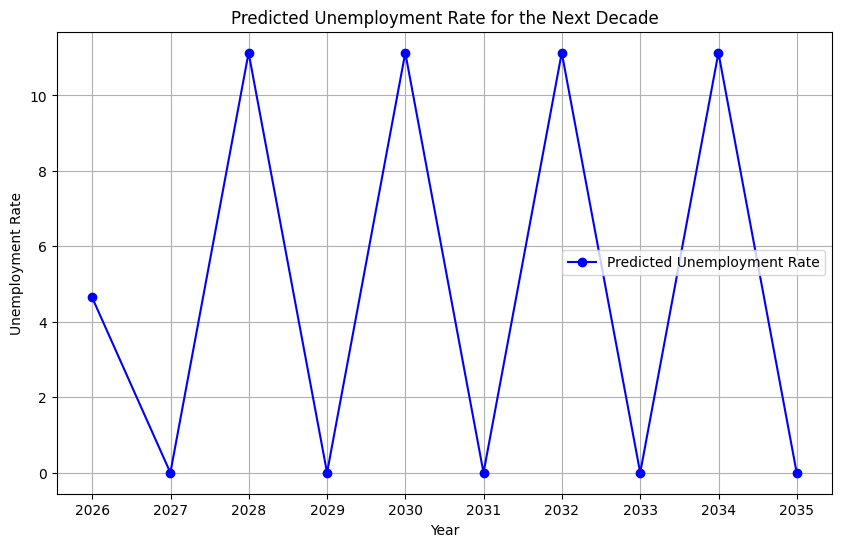

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(predictions_df.index, predictions_df["Predicted Unemployment Rate"], marker='o', linestyle='-', color='b', label='Predicted Unemployment Rate')
plt.title('Predicted Unemployment Rate for the Next Decade')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.grid(True)
plt.legend()
plt.show()

Using Adam as our optimizer:

In [ ]:
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 128, step=16)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    model = RNNModel(input_size=X_train.shape[1], hidden_size=hidden_size, dropout_rate=dropout_rate)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    X_train_tensor = torch.tensor(X_train_part, dtype=torch.float32).unsqueeze(1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train_part.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

    for epoch in range(150):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_val_tensor)

    return val_loss.item()

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("Best Hyperparameters:", study.best_params)

[I 2024-12-12 03:34:24,362] A new study created in memory with name: no-name-e82b4c78-e280-44b4-a284-12d554371ef9
[I 2024-12-12 03:34:44,505] Trial 0 finished with value: 75.93717956542969 and parameters: {'hidden_size': 128, 'dropout_rate': 0.0, 'learning_rate': 0.000491495463043965}. Best is trial 0 with value: 75.93717956542969.
[I 2024-12-12 03:34:52,906] Trial 1 finished with value: 36.88542938232422 and parameters: {'hidden_size': 48, 'dropout_rate': 0.0, 'learning_rate': 0.0023859576468594624}. Best is trial 1 with value: 36.88542938232422.
[I 2024-12-12 03:35:12,961] Trial 2 finished with value: 25.31372833251953 and parameters: {'hidden_size': 128, 'dropout_rate': 0.0, 'learning_rate': 0.00575117850048751}. Best is trial 2 with value: 25.31372833251953.
[I 2024-12-12 03:35:22,898] Trial 3 finished with value: 80.96080780029297 and parameters: {'hidden_size': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0006574975722195169}. Best is trial 2 with value: 25.3137283

Best Hyperparameters: {'hidden_size': 128, 'dropout_rate': 0.4, 'learning_rate': 0.007162196936847229}


In [ ]:
best_params = study.best_params
best_model = RNNModel(
    input_size=X_train.shape[1],
    hidden_size=best_params["hidden_size"],
    dropout_rate=best_params["dropout_rate"]
)
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params["learning_rate"])

# Retrain the model
#for epoch in range(best_params["num_epochs"]):
for epoch in range(num_epochs):
    best_model.train()
    outputs = best_model(X_train_tensor.unsqueeze(1))
    loss = criterion(outputs.squeeze(), y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print(f"Final Training Loss: {loss.item():.4f}")

Epoch [10/1000], Loss: 90.9246
Epoch [20/1000], Loss: 59.1611
Epoch [30/1000], Loss: 43.9186
Epoch [40/1000], Loss: 38.0824
Epoch [50/1000], Loss: 35.1868
Epoch [60/1000], Loss: 32.2952
Epoch [70/1000], Loss: 30.7918
Epoch [80/1000], Loss: 30.0674
Epoch [90/1000], Loss: 29.1659
Epoch [100/1000], Loss: 28.4486
Epoch [110/1000], Loss: 27.9264
Epoch [120/1000], Loss: 27.5473
Epoch [130/1000], Loss: 27.3336
Epoch [140/1000], Loss: 27.0364
Epoch [150/1000], Loss: 27.0001
Epoch [160/1000], Loss: 26.8761
Epoch [170/1000], Loss: 26.5490
Epoch [180/1000], Loss: 26.3666
Epoch [190/1000], Loss: 26.1758
Epoch [200/1000], Loss: 25.9218
Epoch [210/1000], Loss: 25.8696
Epoch [220/1000], Loss: 25.6386
Epoch [230/1000], Loss: 25.6502
Epoch [240/1000], Loss: 25.5185
Epoch [250/1000], Loss: 25.4580
Epoch [260/1000], Loss: 25.3717
Epoch [270/1000], Loss: 25.3655
Epoch [280/1000], Loss: 25.1423
Epoch [290/1000], Loss: 25.2345
Epoch [300/1000], Loss: 25.1542
Epoch [310/1000], Loss: 24.9557
Epoch [320/1000],

In [ ]:
last_input = X_train[-1].reshape(1, -1)
last_input_tensor = torch.tensor(last_input, dtype=torch.float32)

num_years = 10
predictions = []

with torch.no_grad():
    model.eval()
    for _ in range(num_years):
        # Add the sequence dimension (sequence_length = 1 in this case)
        input_tensor = last_input_tensor.unsqueeze(1)  # Shape: [1, 1, num_features]

        prediction = best_model(input_tensor)
        predicted_value = prediction.item()
        predictions.append(predicted_value)

        # Update the input for the next prediction
        new_input = last_input[0][1:].tolist() + [predicted_value]
        last_input_tensor = torch.tensor(new_input, dtype=torch.float32).reshape(1, -1)

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame(predictions, columns=["Predicted Unemployment Rate"])
predictions_df.index = pd.date_range(start='2025', periods=num_years, freq='Y')

print(predictions_df)

            Predicted Unemployment Rate
2025-12-31                     6.529729
2026-12-31                     0.000000
2027-12-31                     8.444262
2028-12-31                     0.000000
2029-12-31                     9.470757
2030-12-31                     0.000000
2031-12-31                     9.664517
2032-12-31                     0.000000
2033-12-31                     9.103032
2034-12-31                     0.000000


<ipython-input-78-bf9c82f81d82>:23: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  predictions_df.index = pd.date_range(start='2025', periods=num_years, freq='Y')


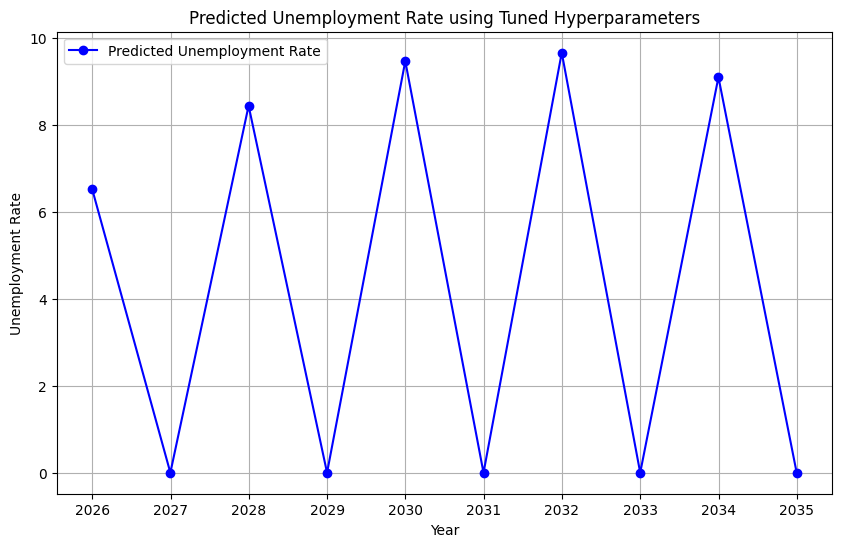

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(predictions_df.index, predictions_df["Predicted Unemployment Rate"], marker='o', linestyle='-', color='b', label='Predicted Unemployment Rate')
plt.title('Predicted Unemployment Rate using Tuned Hyperparameters')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.grid(True)
plt.legend()
plt.show()

Using SGD as our optimizer:

In [ ]:
def objective2(trial):
    # Hyperparameters to tune
    hidden_size = trial.suggest_int("hidden_size", 32, 128, step=16)
    #dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    #num_epochs = trial.suggest_int("num_epochs", 50, 200, step=50)

    model = RNNModel(input_size=X_train.shape[1], hidden_size=hidden_size, dropout_rate=dropout_rate)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    X_train_tensor = torch.tensor(X_train_part, dtype=torch.float32).unsqueeze(1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train_part.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

    #for epoch in range(num_epochs):
    for epoch in range(150):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_val_tensor)

    return val_loss.item()

study = optuna.create_study(direction="minimize")
study.optimize(objective2, n_trials=30)

print("Best Hyperparameters:", study.best_params)

[I 2024-12-12 03:47:02,361] A new study created in memory with name: no-name-9332f64e-c9ab-47e8-9ca5-2a58d4798e89
[I 2024-12-12 03:47:17,673] Trial 0 finished with value: 42.299163818359375 and parameters: {'hidden_size': 96, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.000997318176976181}. Best is trial 0 with value: 42.299163818359375.
[I 2024-12-12 03:47:30,524] Trial 1 finished with value: 87.19739532470703 and parameters: {'hidden_size': 96, 'dropout_rate': 0.0, 'learning_rate': 0.00030963383880315006}. Best is trial 0 with value: 42.299163818359375.
[I 2024-12-12 03:47:53,285] Trial 2 finished with value: 88.10294342041016 and parameters: {'hidden_size': 128, 'dropout_rate': 0.1, 'learning_rate': 0.000331670672973235}. Best is trial 0 with value: 42.299163818359375.
[I 2024-12-12 03:47:56,893] Trial 3 finished with value: 26.580514907836914 and parameters: {'hidden_size': 32, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.005348537804565418}. Best is trial 3 w

Best Hyperparameters: {'hidden_size': 112, 'dropout_rate': 0.5, 'learning_rate': 0.00961522227225996}


In [ ]:
best_params2 = study.best_params
best_model2 = RNNModel(
    input_size=X_train.shape[1],
    hidden_size=best_params["hidden_size"],
    dropout_rate=best_params["dropout_rate"]
)
criterion = nn.MSELoss()
optimizer = optim.SGD(best_model2.parameters(), lr=best_params2["learning_rate"])

# Retrain the model
#for epoch in range(best_params["num_epochs"]):
for epoch in range(num_epochs):
    best_model2.train()
    outputs = best_model2(X_train_tensor.unsqueeze(1))
    loss = criterion(outputs.squeeze(), y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print(f"Final Training Loss: {loss.item():.4f}")

Epoch [10/1000], Loss: 58.9171
Epoch [20/1000], Loss: 42.2599
Epoch [30/1000], Loss: 38.0817
Epoch [40/1000], Loss: 35.1138
Epoch [50/1000], Loss: 32.9867
Epoch [60/1000], Loss: 31.1846
Epoch [70/1000], Loss: 29.6339
Epoch [80/1000], Loss: 28.9252
Epoch [90/1000], Loss: 27.8984
Epoch [100/1000], Loss: 27.2526
Epoch [110/1000], Loss: 26.5464
Epoch [120/1000], Loss: 26.0712
Epoch [130/1000], Loss: 25.6680
Epoch [140/1000], Loss: 25.1724
Epoch [150/1000], Loss: 24.7685
Epoch [160/1000], Loss: 24.5549
Epoch [170/1000], Loss: 24.3843
Epoch [180/1000], Loss: 24.1243
Epoch [190/1000], Loss: 23.8622
Epoch [200/1000], Loss: 23.6706
Epoch [210/1000], Loss: 23.6794
Epoch [220/1000], Loss: 23.5763
Epoch [230/1000], Loss: 23.2425
Epoch [240/1000], Loss: 23.2540
Epoch [250/1000], Loss: 23.0910
Epoch [260/1000], Loss: 23.1676
Epoch [270/1000], Loss: 23.1090
Epoch [280/1000], Loss: 22.8509
Epoch [290/1000], Loss: 22.9704
Epoch [300/1000], Loss: 22.9344
Epoch [310/1000], Loss: 22.8604
Epoch [320/1000],

In [ ]:
# Use the last input from training data
last_input = X_train[-1].reshape(1, -1)
last_input_tensor = torch.tensor(last_input, dtype=torch.float32)

num_years = 10
predictions = []

with torch.no_grad():
    model.eval()
    for _ in range(num_years):
        #prediction = model(last_input_tensor.unsqueeze(1))
        prediction = best_model2(last_input_tensor.unsqueeze(1))
        predicted_value = prediction.item()
        predictions.append(predicted_value)
        last_input_tensor = torch.tensor([last_input[0][1:].tolist() + [predicted_value]], dtype=torch.float32)

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame(predictions, columns=["Predicted Unemployment Rate"])
predictions_df.index = pd.date_range(start='2025', periods=num_years, freq='Y')

print(predictions_df)

            Predicted Unemployment Rate
2025-12-31                     3.936354
2026-12-31                     0.047824
2027-12-31                    10.400182
2028-12-31                     1.855074
2029-12-31                     0.000000
2030-12-31                     9.716789
2031-12-31                     3.309646
2032-12-31                     0.000000
2033-12-31                     8.783912
2034-12-31                     8.195192


<ipython-input-82-1ce671bd5646>:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  predictions_df.index = pd.date_range(start='2025', periods=num_years, freq='Y')


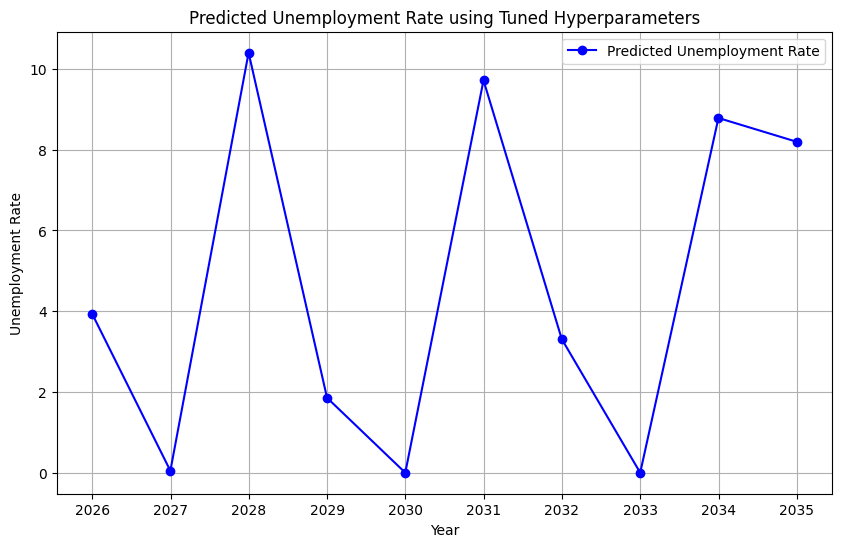

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(predictions_df.index, predictions_df["Predicted Unemployment Rate"], marker='o', linestyle='-', color='b', label='Predicted Unemployment Rate')
plt.title('Predicted Unemployment Rate using Tuned Hyperparameters')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.grid(True)
plt.legend()
plt.show()

Comparing the final test loss when using Adam vs SGD over multiple runs, we can confidently say that optimizing using Adam leads to more accurate predictions

# Feature Importance (Milestone 4)

In [ ]:
# Load the necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

Feature Permutation Analysis

In [ ]:
# Best model from milestone 3
best_model.eval()  # Ensure the model is in evaluation mode

# Convert test data to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add sequence dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Baseline performance
with torch.no_grad():
    y_pred = best_model(X_test_tensor).squeeze().numpy()
baseline_score = mean_squared_error(y_test, y_pred)

# Feature Permutation Importance
importances = []
for col in range(X_test.shape[1]):
    X_test_permuted = X_test_tensor.clone()
    permuted_feature = np.random.permutation(X_test[:, col])
    X_test_permuted[:, 0, col] = torch.tensor(permuted_feature, dtype=torch.float32)

    # Evaluate performance with the permuted feature
    with torch.no_grad():
        y_pred_permuted = best_model(X_test_permuted).squeeze().numpy()
    permuted_score = mean_squared_error(y_test, y_pred_permuted)

    # Calculate importance as the increase in error
    importances.append(permuted_score - baseline_score)

# Visualization
feature_importances = np.array(importances)
sorted_idx = np.argsort(feature_importances)

feature_names = [
    '_id', 'Area Name', 'Area Type', 'Year', 'Month', 'Date_Numeric',
    'Seasonally Adjusted(Y/N)', 'Status', 'Labor Force', 'Employment',
    'Unemployment', 'Benchmark', 'Employment Rate'
]

# Ensure the feature_names list matches the order and length of X_test columns
assert len(feature_names) == X_test.shape[1], "Feature names do not match the number of columns in X_test."

# Permutation Importance Visualization with Feature Names
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in sorted_idx], feature_importances[sorted_idx])  # Replace indices with names
plt.xlabel("Increase in MSE")
plt.title("Feature Permutation Importance")
plt.show()

# Updated Results DataFrame
results = pd.DataFrame({
    "Feature": [feature_names[i] for i in range(len(feature_importances))],
    "Importance (Increase in MSE)": feature_importances
}).sort_values(by="Importance (Increase in MSE)", ascending=False)

# Save results
results.to_csv("feature_importance_results.csv", index=False)
print(results)

ValueError: could not determine the shape of object type 'Series'

In [ ]:
feature_names = [
    '_id', 'Area Name', 'Area Type', 'Year', 'Month', 'Date_Numeric',
    'Seasonally Adjusted(Y/N)', 'Status', 'Labor Force', 'Employment',
    'Unemployment', 'Benchmark', 'Employment Rate'
]

# Prepare data for SHAP
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

# Define a wrapper for the RNN model to be compatible with SHAP
class RNNWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, data):
        # Ensure data is in the correct shape for the model
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(1)  # Add sequence dimension
        with torch.no_grad():
            predictions = self.model(data_tensor).squeeze().numpy()
        # Return a 1D array of predictions
        return predictions.ravel()

# Wrap the trained model
wrapped_model = RNNWrapper(best_model)

background = shap.sample(X_test, 100)  # Use 100 samples as the background data

# SHAP Explainer
explainer = shap.KernelExplainer(
    wrapped_model.predict,
    background
)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test, nsamples=100)

# Convert SHAP values to a DataFrame for analysis
shap_df = pd.DataFrame(shap_values, columns=feature_names)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# SHAP Bar Plot for Average Feature Importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")


## Conclusions Based on Feature Importance and SHAP Analysis

The results of the feature importance analysis using **Permutation Importance** and **SHAP** provide valuable insights into the key factors influencing the unemployment rate prediction model. Below is a detailed interpretation of the results:

---

### **1. Permutation Importance Analysis**
The permutation importance results reveal the following:

- **Top Features**:
  - **Year**: This is the most influential feature, indicating that temporal trends significantly impact unemployment predictions.
  - **_id**: Although `_id` is a dataset-specific feature, its high importance suggests it might inadvertently capture patterns related to data preprocessing or indexing.
  - **Date_Numeric**: Another time-related feature that emphasizes the importance of temporal information in the predictions.
  - **Employment Rate** and **Unemployment**: Both features are directly tied to the prediction target, making them critical for the model's accuracy.

- **Low Importance Features**:
  - Features such as `Area Name`, `Area Type`, and `Month` have minimal influence, suggesting that they do not provide substantial predictive value and could potentially be removed to simplify the model.

---

### **2. SHAP Summary Analysis**
The SHAP values give a deeper understanding of how each feature contributes to individual predictions:

- **Top Contributors**:
  - **Employment Rate**: The most impactful feature overall, with both positive and negative contributions depending on the context of the data.
  - **Unemployment**: Highly influential and complementary to `Employment Rate` in explaining predictions.
  - **Date_Numeric** and **Year**: Temporal features again demonstrate their importance, capturing trends over time.

- **Feature Interaction**:
  - SHAP's summary plot shows clear patterns where higher `Employment Rate` values lower unemployment predictions, while lower values increase unemployment predictions.
  - Temporal features (`Year`, `Date_Numeric`) play a consistent role in prediction dynamics.

---

### **3. SHAP Detailed Impact Plot**
The detailed SHAP plot highlights the specific impacts of feature values:

- Features such as `Employment Rate` and `Unemployment` show strong directional influence on predictions. For example:
  - Higher `Employment Rate` values generally decrease predicted unemployment.
  - Higher `Unemployment` values predict higher unemployment rates.
- Temporal features like `Year` and `Date_Numeric` consistently show significant impacts, likely capturing cyclical trends or seasonal patterns in employment data.

---